# INIT

## load pack

In [1]:
import sys
sys.path.append("../POS_tagging/")
sys.path.append("../../../pomegranate/")
sys.path.append(r"../../../WhoCell\pomegranate")
sys.path.append(r"../../../WhoCell")
sys.path.append(r"../../../WhoCell/")
sys.path.append(r"../../../WhoCell/who_cell/")
sys.path.append(r"../../../WhoCell/who_cell/models/")
sys.path.append(r"../../../WhoCell/who_cell/simulation/")
sys.path.append(r"../../../WhoCell/who_cell/experiments/")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import string

from collections import Counter
from IPython.core.display import HTML
from itertools import chain
from collections import Counter, defaultdict
from helpers import show_model, Dataset
import pandas as pd
import seaborn as sns
import itertools
from functools import reduce

from pomegranate import State, HiddenMarkovModel, DiscreteDistribution

from simulation_for_gibbs import Simulator_for_Gibbs
from gibbs_sampler import GibbsSampler
from experiment_report import ExperimentReport 
from gibbs_experiments import GibbsExperiment
from pos_data_builder import PosDataBuilder
from pos_code_base import PosCodeBase


In [3]:
# %connect_info
%load_ext autoreload

import warnings
warnings.filterwarnings('ignore')

# real problem

In [4]:
data_builder = PosDataBuilder()
code_base = PosCodeBase()

# Markovien problem - not only observed

In [5]:
all_pc_results = {}
for pc in [1,0.5,0.2,0.05] : 
    data_builder = PosDataBuilder()
    code_base = PosCodeBase()

    few_obs_test_set_words,few_obs_test_set_tags = data_builder.get_experiment_sets_from_markovien_sets(pc,30,True)

    transitions_probs,transitions_probs_df = data_builder.get_known_transitions()

    _args = {"test_set_words":few_obs_test_set_words,
    "start_probs":data_builder._build_starting_probabilites(),
    "emms_probs":data_builder._build_emissions_probabilites(),
    "number_of_iters":50,
    "N":30,
    "is_only_observed":False,
    "description":f" {pc}",
    "known_transitions":transitions_probs_df,
    "comper_transitions":None,
    "comper_transitions_title" :None,
    "state_order_for_plot":data_builder.STATE_ORDER_TO_PLOT,
    "title":f"P(C) = {pc},markov"}
    _experiment_results = code_base.run_pos_experiment(**_args)
    
    all_pc_results[f'P(C) = {pc}'] ={'transitions_probs':transitions_probs,
                                     '_known_N':30,
                                     '_experiment_results':_experiment_results}

start M-H sampling


100%|███████████████████████████████████████████| 50/50 [34:53<00:00, 41.88s/it]


start M-H sampling


100%|███████████████████████████████████████████| 50/50 [18:07<00:00, 21.75s/it]


start M-H sampling


100%|███████████████████████████████████████████| 50/50 [09:23<00:00, 11.26s/it]


start M-H sampling


100%|███████████████████████████████████████████| 50/50 [06:13<00:00,  7.47s/it]


In [6]:
er = ExperimentReport()

experiments_name_list = list(all_pc_results.keys())
transitions_results_list = [all_pc_results[experiments_name_list[0]]['_experiment_results']['transitions'],
                            all_pc_results[experiments_name_list[1]]['_experiment_results']['transitions'],
                            all_pc_results[experiments_name_list[2]]['_experiment_results']['transitions'],
                            all_pc_results[experiments_name_list[3]]['_experiment_results']['transitions']]
known_probs_list = [all_pc_results[experiments_name_list[0]]['transitions_probs'],
                    all_pc_results[experiments_name_list[1]]['transitions_probs'],
                    all_pc_results[experiments_name_list[2]]['transitions_probs'],
                    all_pc_results[experiments_name_list[3]]['transitions_probs']]



__l1_distance = lambda dist,state,known : abs(dist[state]-known) if state in dist.keys() else known
__cross_entropy_distance = lambda dist,state,known : -1*known*np.log(dist[state]) if state in dist.keys() else (-1*known*np.log(0.0001))

_l1_distance = lambda known_dist,comp_dist:sum(([__l1_distance(comp_dist,state,prob) for state,prob in known_dist.items()]))
_cross_entropy_distance = lambda known_dist,comp_dist:sum([__cross_entropy_distance(comp_dist,state,prob) for state,prob in known_dist.items()])

l1_distance = lambda known_trns,comp_trans : np.mean([_l1_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])
cross_entropy_distance = lambda known_trns,comp_trans : np.mean([_cross_entropy_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])

_trajectory_prob = lambda traj,model_trans:reduce(lambda x,y:x*y,[(model_trans[_f][_t] if _t in model_trans[_f].keys() else 0) for _f,_t in zip(traj,traj[1:])])


all_l1_results = {}
all_ce_results = {}
for _trans_list,exp_name,transitions_probs in zip(transitions_results_list,experiments_name_list,known_probs_list) : 
    l1_dist = [l1_distance(transitions_probs,_t) for _t in _trans_list]
    ce_dist = [cross_entropy_distance(transitions_probs,_t) for _t in _trans_list]
    
    all_l1_results[exp_name] = l1_dist
    all_ce_results[exp_name] = ce_dist



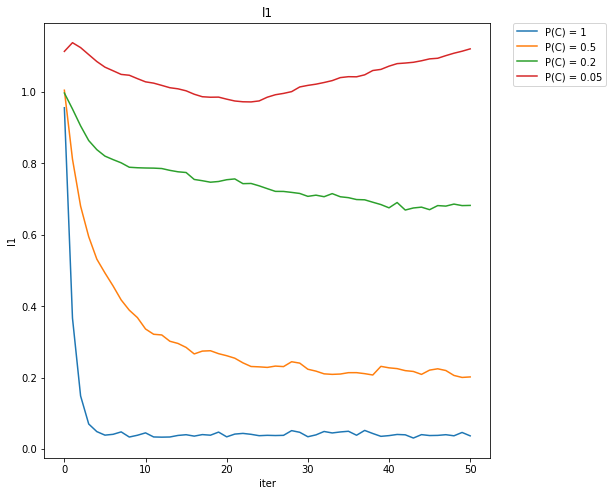

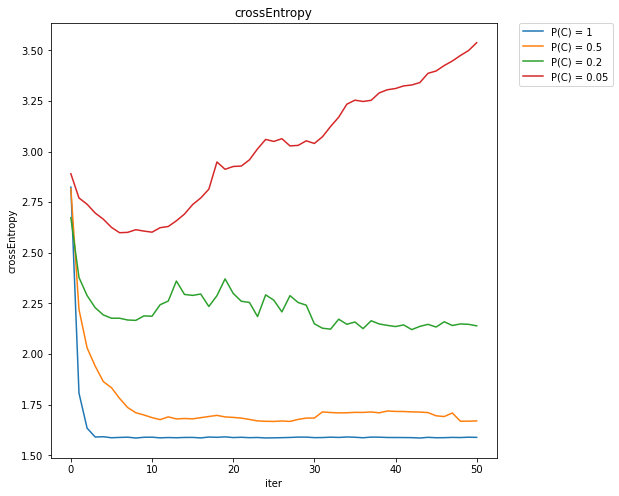

In [7]:


for all_results,name in zip([all_l1_results,all_ce_results],['l1','crossEntropy']) : 
    fig, sub = plt.subplots(1,1,figsize=(8, 8))
    model_results_df = pd.DataFrame(all_results)

    sns.lineplot(data=model_results_df, ax=sub, legend='full', dashes=False)
    sub.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sub.set_title(f"{name}")
    sub.set_xlabel("iter")
    sub.set_ylabel(f"{name}")

    plt.subplots_adjust(hspace=0.8)
    plt.subplots_adjust(wspace=0.8)

    plt.show()

In [40]:
def extrect_only_observed(ws,states_of_w) : 
    transition_normalization = lambda dic: {k:{kk:vv/sum(v.values()) for kk,vv in v.items()} for k,v in dic.items()}
    _all_obsarved_transitions = []
    for w,states in zip(ws,states_of_w) : 
        _all_obsarved_transitions.append([(states[idx],states[idx+1]) for idx,(_fw,_tw) in enumerate(zip(w,w[1:])) if (_tw - _fw) == 1])
    all_obsarved_transitions = Counter(chain(*_all_obsarved_transitions))

    transition_matrix = {}
    for (_f,_t),count in all_obsarved_transitions.items() : 
        if _f not in transition_matrix.keys() :
            transition_matrix[_f] = {_t:count}
        else : 
            transition_matrix[_f][_t] = count
    norm_transition_matrix = transition_normalization(transition_matrix)
    return norm_transition_matrix

In [41]:
er = ExperimentReport()

experiments_name_list = list(all_pc_results.keys())
transitions_results_list = [list(map(lambda x:extrect_only_observed(x[0],x[1]),zip(all_pc_results[experiments_name_list[0]]['_experiment_results']['ws'],all_pc_results[experiments_name_list[0]]['_experiment_results']['states_picked_by_w']))),
                            list(map(lambda x:extrect_only_observed(x[0],x[1]),zip(all_pc_results[experiments_name_list[1]]['_experiment_results']['ws'],all_pc_results[experiments_name_list[1]]['_experiment_results']['states_picked_by_w']))),
                            list(map(lambda x:extrect_only_observed(x[0],x[1]),zip(all_pc_results[experiments_name_list[2]]['_experiment_results']['ws'],all_pc_results[experiments_name_list[2]]['_experiment_results']['states_picked_by_w']))),
                            list(map(lambda x:extrect_only_observed(x[0],x[1]),zip(all_pc_results[experiments_name_list[3]]['_experiment_results']['ws'],all_pc_results[experiments_name_list[3]]['_experiment_results']['states_picked_by_w'])))]
known_probs_list = [all_pc_results[experiments_name_list[0]]['transitions_probs'],
                    all_pc_results[experiments_name_list[1]]['transitions_probs'],
                    all_pc_results[experiments_name_list[2]]['transitions_probs'],
                    all_pc_results[experiments_name_list[3]]['transitions_probs']]



__l1_distance = lambda dist,state,known : abs(dist[state]-known) if state in dist.keys() else known
__cross_entropy_distance = lambda dist,state,known : -1*known*np.log(dist[state]) if state in dist.keys() else (-1*known*np.log(0.0001))

_l1_distance = lambda known_dist,comp_dist:sum(([__l1_distance(comp_dist,state,prob) for state,prob in known_dist.items()]))
_cross_entropy_distance = lambda known_dist,comp_dist:sum([__cross_entropy_distance(comp_dist,state,prob) for state,prob in known_dist.items()])

l1_distance = lambda known_trns,comp_trans : np.mean([_l1_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])
cross_entropy_distance = lambda known_trns,comp_trans : np.mean([_cross_entropy_distance(dist,comp_trans[state]) for state,dist in known_trns.items()])

_trajectory_prob = lambda traj,model_trans:reduce(lambda x,y:x*y,[(model_trans[_f][_t] if _t in model_trans[_f].keys() else 0) for _f,_t in zip(traj,traj[1:])])


all_l1_results = {}
all_ce_results = {}
for _trans_list,exp_name,transitions_probs in zip(transitions_results_list,experiments_name_list,known_probs_list) : 
    l1_dist = [l1_distance(transitions_probs,_t) for _t in _trans_list]
    ce_dist = [cross_entropy_distance(transitions_probs,_t) for _t in _trans_list]
    
    all_l1_results[exp_name] = l1_dist
    all_ce_results[exp_name] = ce_dist



KeyError: 'X'

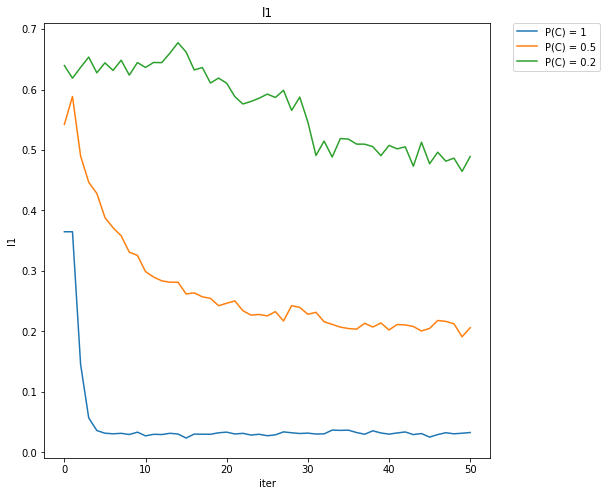

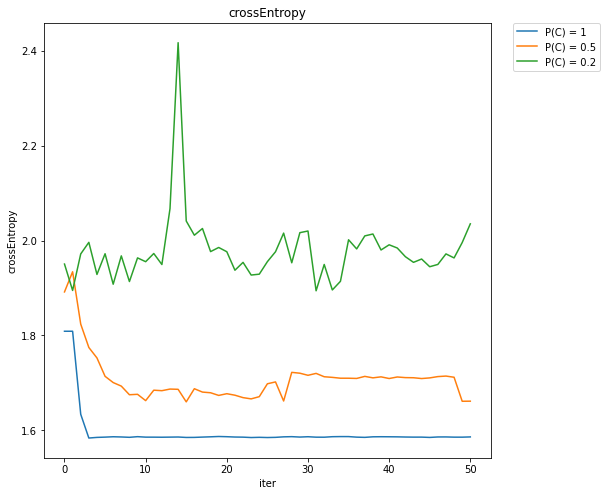

In [42]:


for all_results,name in zip([all_l1_results,all_ce_results],['l1','crossEntropy']) : 
    fig, sub = plt.subplots(1,1,figsize=(8, 8))
    model_results_df = pd.DataFrame(all_results)

    sns.lineplot(data=model_results_df, ax=sub, legend='full', dashes=False)
    sub.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    sub.set_title(f"{name}")
    sub.set_xlabel("iter")
    sub.set_ylabel(f"{name}")

    plt.subplots_adjust(hspace=0.8)
    plt.subplots_adjust(wspace=0.8)

    plt.show()